# Classify Waste Products Using Transfer Learning
The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images. By the end of this project, you will have trained, fine-tuned, and evaluated a model using transfer learning, which can then be applied to real-world waste management processes.

In this notebook, we will build an AI-powered solution using transfer learning (VGG16) to classify waste images into recyclable and organic categories.

In [1]:
# Import necessary libraries
# Standard libraries for numerical computations and OS operations
import numpy as np
import os
import glob
import warnings

# Libraries for visualization and image processing
import matplotlib.pyplot as plt
# imread is a utility to read images, useful for displaying images in the notebook.
from matplotlib.image import imread

# Suppress TensorFlow debugging logs to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# TensorFlow and Keras modules for building and training the model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
# ImageDataGenerator is used for augmenting image data and preprocessing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# ModelCheckpoint saves the model at intervals, It ensures that you have the best model saved even if the later epochs do not perform as well.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# scikit-learn for evaluation metrics
from sklearn import metrics

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

# Task 1: Print the version of TensorFlow
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


### Data Preparation

In [2]:
# Download the dataset from a remote URL
# We use the 'requests' module to download a ZIP file containing the dataset.
import requests
import zipfile
# tqdm is used to show a progress bar during extraction
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

In [3]:
print("Downloading file...")
# Streaming the download to handle large files without consuming too much memory.
with requests.get(url, stream=True) as response:
    response.raise_for_status()  # Check if the download request was successful.
    with open(file_name, 'wb') as f:   # wb -> writing in binary mode
        # Download the file in chunks of 8192 bytes.
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
print("Download complete!")

Download complete!


In [4]:
# Extract the downloaded ZIP file with a progress bar
# Define a function that uses the 'zipfile' module to extract the ZIP archive.
def extract_file_with_progress(file_name):
    print("Extracting file with progress...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        # 'infolist()' gets a list of all members (files/folders) in the ZIP archive.
        members = zip_ref.infolist()
        # Initialize a progress bar with the total number of files.
        with tqdm(total=len(members), unit='file') as progress_bar:
            # Loop through each member and extract it.
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)  # Update the progress bar by one file.
    print("Finished extracting file")

# Extract the dataset.
extract_file_with_progress(file_name)

Extracting file with progress...


100%|██████████| 1207/1207 [00:00<00:00, 3570.88file/s]

Finished extracting file


In [5]:
# Remove the ZIP file after extraction to free up space.
print("Cleaning up: Removing the ZIP file...")
import os  # 'os' is used to interact with the operating system.
os.remove(file_name)
print("ZIP file removed.")

Cleaning up: Removing the ZIP file...
ZIP file removed.


### Set Parameters and Create ImageDataGenerators

In [6]:
# Define image dimensions, batch size, number of epochs, and other parameters.
img_rows, img_cols = 150, 150         # Dimensions for resizing images.
batch_size = 32                       # Number of images per batch.
n_epochs = 10                         # Number of epochs for training.
n_classes = 2                         # Two classes: Organic (O) and Recyclable (R).
val_split = 0.2                       # 20% of data will be used for validation.
verbosity = 1                         # Verbosity mode for training logs.
path = 'o-vs-r-split/train/'           # Directory path for training data.
path_test = 'o-vs-r-split/test/'       # Directory path for testing data.
input_shape = (img_rows, img_cols, 3)   # Input shape for the model (150x150 images with 3 color channels).
labels = ['O', 'R']                   # List of class labels.
seed = 42                             # Random seed for reproducibility.

In [7]:
# Create ImageDataGenerators for augmenting and rescaling images.
# For the training set, we apply rescaling and data augmentation (shifts and flips).
train_datagen = ImageDataGenerator(
    validation_split=val_split,   # Reserve a portion for validation.
    rescale=1.0/255.0,            # Scale pixel values to [0, 1].
    width_shift_range=0.1,        # Randomly shift images horizontally.
    height_shift_range=0.1,       # Randomly shift images vertically.
    horizontal_flip=True          # Randomly flip images horizontally.
)

# For the validation set, we only apply rescaling.
val_datagen = ImageDataGenerator(
    validation_split=val_split,
    rescale=1.0/255.0,
)

# For the test set, we apply only rescaling.
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [8]:
# Create the training generator.
train_generator = train_datagen.flow_from_directory(
    directory=path,
    seed=seed,
    batch_size=batch_size,
    class_mode='binary',          # Since there are two classes, use binary mode.
    shuffle=True,                 # Shuffle the data for training.
    target_size=(img_rows, img_cols),
    subset='training'             # Specify that this generator is for training.
)

# Create the validation generator.
val_generator = val_datagen.flow_from_directory(
    directory=path,
    seed=seed,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,                 # Shuffle the validation data as well.
    target_size=(img_rows, img_cols),
    subset='validation'           # Specify that this generator is for validation.
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [9]:
## Create a Test Generator
test_generator = test_datagen.flow_from_directory(
    directory=path_test,         # Directory where test images are stored.
    class_mode='binary',         # Binary classification (organic vs recyclable).
    seed=seed,                   # For reproducibility.
    batch_size=batch_size,       # Number of images per batch.
    shuffle=False,               # Do not shuffle the test data.
    target_size=(img_rows, img_cols)  # Resize all images to 150x150.
)

# Print the number of batches in the test generator.
print("Number of batches in test_generator:", len(test_generator))

Found 200 images belonging to 2 classes.
Number of batches in test_generator: 7


### Load and Visualize Some Training Images

<class 'list'>
<class 'numpy.ndarray'>
Labels: ['O', 'O', 'O', 'O', 'O']


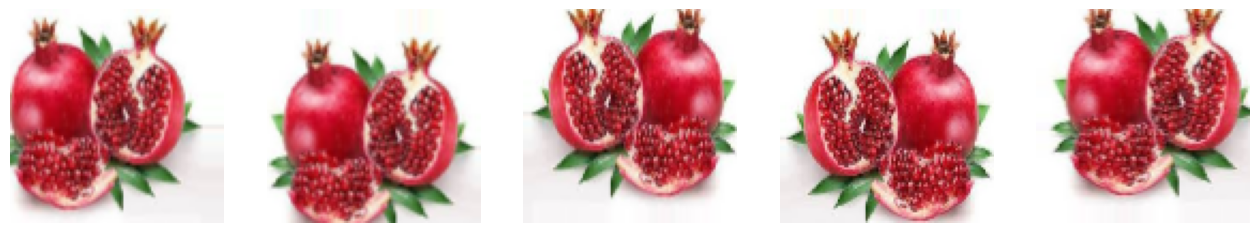

In [25]:
# 'Path' from pathlib helps us extract parts of the file path (like the folder name).
from pathlib import Path

# Load and Visualize Some Training Images
# Instead of using the original image size, we're resizing them to 100×100 pixels.
# Smaller images require less memory and processing power (for this demonstration)
IMG_DIM = (100, 100)

# Use the 'glob' module to get file paths for images in the "O" (Organic) folder
train_files = glob.glob('./o-vs-r-split/train/O/*')
# We use only the first 20 images (for this demonstration)
train_files = train_files[:20]

# Load the images and convert them to numpy arrays.
train_imgs = [tf.keras.preprocessing.image.img_to_array(
                # Load the image
                tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM))
                for img in train_files]
# train_imgs is a List of array
print(type(train_imgs))
# Transform the list into an array numpy
train_imgs = np.array(train_imgs)
print(type(train_imgs))

# Get the label for each image (In this case, the label is the parent folder name)
# If a file path is like ./o-vs-r-split/train/O/image1.jpg, the parent folder is "O"
train_labels = [Path(fn).parent.name for fn in train_files]

# Now, we create a data generator to augment a single image.
# We'll pick the first image (img_id = 0) and generate 5 augmented versions.
img_id = 0
O_generator = train_datagen.flow(
    train_imgs[img_id:img_id+1],         # Select the first image (array)
    train_labels[img_id:img_id+1],         # The corresponding label ("O").
    batch_size=1
)

# If you call next() on a generator in Python, it produce one batch of data (in this case, a single augmented image and its label)
# Generate 5 augmented images.
O = [next(O_generator) for i in range(5)]

# Plot the augmented images using matplotlib.
fig, ax = plt.subplots(1, 5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
for i in range(5):
    ax[i].imshow(O[i][0][0])
    ax[i].axis('off')  # Hide the axis for clarity.
plt.show()

In [22]:
# Show what include train_files variable
train_files

['./o-vs-r-split/train/O/O_16.jpg',
 './o-vs-r-split/train/O/O_1260.jpg',
 './o-vs-r-split/train/O/O_492.jpg',
 './o-vs-r-split/train/O/O_801.jpg',
 './o-vs-r-split/train/O/O_310.jpg',
 './o-vs-r-split/train/O/O_1224.jpg',
 './o-vs-r-split/train/O/O_181.jpg',
 './o-vs-r-split/train/O/O_361.jpg',
 './o-vs-r-split/train/O/O_1271.jpg',
 './o-vs-r-split/train/O/O_1042.jpg',
 './o-vs-r-split/train/O/O_359.jpg',
 './o-vs-r-split/train/O/O_1356.jpg',
 './o-vs-r-split/train/O/O_642.jpg',
 './o-vs-r-split/train/O/O_978.jpg',
 './o-vs-r-split/train/O/O_1252.jpg',
 './o-vs-r-split/train/O/O_1313.jpg',
 './o-vs-r-split/train/O/O_1007.jpg',
 './o-vs-r-split/train/O/O_1392.jpg',
 './o-vs-r-split/train/O/O_631.jpg',
 './o-vs-r-split/train/O/O_1135.jpg']

### Model Building

In [18]:
# Build the Base Model Using VGG16
from tensorflow.keras.applications import vgg16

# Define the input shape expected by VGG16.
input_shape = (150, 150, 3)

# Load the VGG16 model without its top layers.
vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Get the output of the last convolutional layer in VGG16.
output = vgg.layers[-1].output

# The output of VGG16 is a multi-dimensional tensor. Flattening converts it into a one-dimensional vector.
output = tf.keras.layers.Flatten()(output)

# Create a new model (basemodel) that starts with VGG16's input and ends with the flattened output.
basemodel = Model(vgg.input, output)

# Freeze all layers of the basemodel so they are not updated during training.
for layer in basemodel.layers:
    layer.trainable = False

# Retrieve the output shape (number of features) from the basemodel.
input_shape = basemodel.output_shape[1]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# The output of basemodel (the input for the next level in the final model)
input_shape

8192

In [19]:
# Build the Final Model by Adding New Layers
model = Sequential()
# Add the frozen base model (VGG16 without top layers).
model.add(basemodel)
# First fully connected layer with 512 neurons.
model.add(Dense(512, activation='relu'))
# Apply dropout (30% of neurons dropped) to reduce overfitting.
model.add(Dropout(0.3))
# Second fully connected layer with 512 neurons.
model.add(Dense(512, activation='relu'))
# Apply dropout again.
model.add(Dropout(0.3))
# Final layer for binary classification (organic vs recyclable).
model.add(Dense(1, activation='sigmoid'))

In [20]:
# Print the summary of the final model.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 8192)                │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Compile the Model

In [26]:
# Compile the model with the specified parameters.
model.compile(
    loss='binary_crossentropy',                   # Loss function for binary classification.
    optimizer=optimizers.RMSprop(learning_rate=1e-4),  # Optimizer with a small learning rate.
    metrics=['accuracy']                          # Metrics to evaluate during training.
)

print("Model compiled successfully!")

Model compiled successfully!


In [27]:
# LearningRateScheduler:adjusts the learning rate during training according to a schedule
# checkpoint_path: this variable defines the file name (or path) where the best version of the model will be saved during training.

from tensorflow.keras.callbacks import LearningRateScheduler
checkpoint_path = 'O_R_tlearn_vgg16.keras'

In [28]:
# Define a custom callback to record losses and print the learning rate at the end of each epoch.
class LossHistory_(tf.keras.callbacks.Callback):
    # This method is called at the beginning of training.
    def on_train_begin(self, logs={}):
      # initializes empty lists to keep track of the loss values and learning rates.
        self.losses = []  # List to store the loss after each epoch.
        self.lr = []      # List to store the learning rate for each epoch

    # This method is called at the end of each epoch.
    def on_epoch_end(self, epoch, logs={}):
        # it appends the current loss and learning rate to these lists and prints the learning rate.
        # Append the training loss for the current epoch.
        self.losses.append(logs.get('loss'))
        # Append the learning rate computed for the current epoch.
        self.lr.append(exp_decay(epoch))
        # Print the learning rate using the length of the losses list
        print('lr:', exp_decay(len(self.losses)))


In [29]:
# This function computes a new learning rate for a given epoch using an exponential decay formula.
# As the epoch number increases, the learning rate decreases.
def exp_decay(epoch):
    initial_lrate = 1e-4  # Starting learning rate.
    k = 0.1               # Decay rate constant.
    # The learning rate decays exponentially with the epoch number.
    lrate = initial_lrate * np.exp(-k * epoch)
    return lrate

In [30]:
# An instance of the custom callback that records losses and learning rates.
loss_history_ = LossHistory_()

# An instance of the LearningRateScheduler that adjusts the learning rate at each epoch according to our exp_decay function.
lrate_ = LearningRateScheduler(exp_decay)

In [31]:
keras_callbacks = [
      # EarlyStopping: Monitors the val_loss and stops training if it does not improve
      EarlyStopping(monitor='val_loss',
                    patience=4,          # Stop training if 'val_loss' does not improve for 4 epochs.
                    mode='min',          # We want the 'val_loss' to decrease.
                    min_delta=0.01),     # Only consider improvements greater than 0.01.
      # ModelCheckpoint: Saves the model to the specified checkpoint_path
      ModelCheckpoint(checkpoint_path,
                      monitor='val_loss',
                      save_best_only=True,  # Save only the best model based on validation loss.
                      mode='min')
]


In [32]:
# Combining All Callbacks into a Single List
# This list will be passed to the model.fit() function
# In this way these actions (adjusting learning rate, early stopping, etc.) occur during training.
callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

### Training the Model

In [34]:
extract_feat_model = model.fit(
    train_generator,        # Starts the training process using the training data generator
    steps_per_epoch=5,      # Number of batch iterations per epoch.
    epochs=10,              # Train for 10 epochs.
    callbacks=callbacks_list_,   # Use our callbacks during training.
    validation_data=val_generator,  # Use validation data for evaluation.
    validation_steps=val_generator.samples // batch_size,  # How many validation steps per epoch.
    verbose=1               # Print training progress.
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4481 - loss: 0.7836lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 21s/step - accuracy: 0.4578 - loss: 0.7777 - val_accuracy: 0.7448 - val_loss: 0.5806 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6997 - loss: 0.6029lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 22s/step - accuracy: 0.6987 - loss: 0.6025 - val_accuracy: 0.8229 - val_loss: 0.5005 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7716 - loss: 0.5062lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 33s/step - accuracy: 0.7742 - loss: 0.5040 - val_accuracy: 0.8229 - val_loss: 0.4594 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7356 - loss: 0.4993lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 34s/step - accuracy: 0.7339 - loss: 0.5024 - val_accuracy: 0.8542 - val_loss: 0.4299 - learning_rate: 7.4082e-05
Epoch 

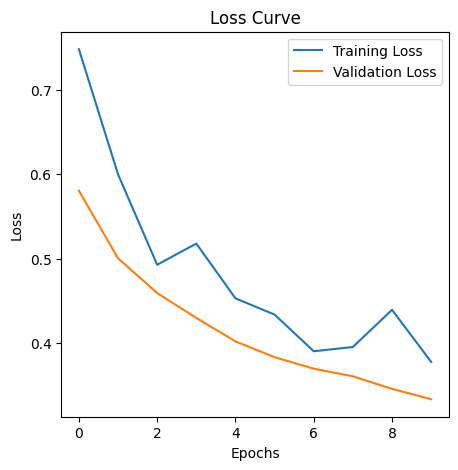

In [35]:
# Plotting the Loss Curve
history = extract_feat_model  # The training history is stored in this variable.

# Plot the loss curves for both training and validation sets.
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

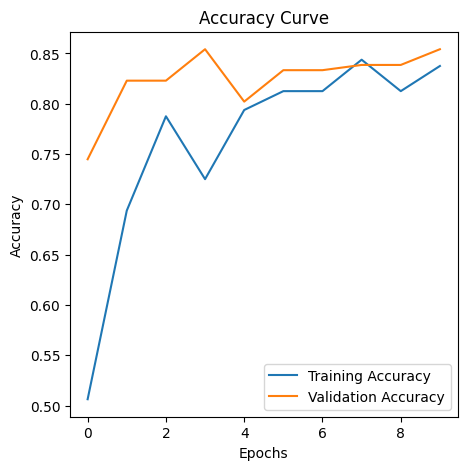

In [36]:
# Plot Accuracy Curves for Training and Validation Sets
# 'extract_feat_model' contains the training history including loss and accuracy for each epoch.

# Create a new figure with specified size.
plt.figure(figsize=(5, 5))

# Plot the training accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot the validation accuracy over epochs.
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Set the title of the plot.
plt.title('Accuracy Curve')

# Label the x-axis and y-axis.
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to differentiate the training and validation curves.
plt.legend()

# Display the plot.
plt.show()

### Fine-Tuning model

In [37]:
# Rebuild the Base Model Using VGG16
# Define the expected input shape for our images.
input_shape = (150, 150, 3)

# Load the VGG16 model pre-trained on ImageNet.
vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Get the output of the last convolutional layer of VGG16.
output = vgg.layers[-1].output

# Flatten the output to convert the multi-dimensional tensor into a 1D vector.
output = tf.keras.layers.Flatten()(output)

# Create a new model that goes from VGG16's input to the flattened output.
basemodel = Model(vgg.input, output)

In [38]:
# Set all layers of the basemodel to not trainable (all layers are frozen)
for layer in basemodel.layers:
    layer.trainable = False

# Display the names of the layers to see what we have.
display([layer.name for layer in basemodel.layers])

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

In the next snipept of code, only the top part of VGG16 will be updated during training (fine-tuning), while earlier layers remain fixed.

In [39]:
# We'll now fine-tune by making the layers starting from a specific layer trainable.
# We use a flag to decide when to start setting layers to trainable.
set_trainable = False

# Loop through each layer in the basemodel.
for layer in basemodel.layers:
    # When we reach the layer named 'block5_conv3', we start unfreezing.
    if layer.name in ['block5_conv3']:
        set_trainable = True
    # Set the layer trainable status based on the flag.
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Print out each layer name along with whether it is trainable.
for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [40]:
# Build the final model
# Create a new Sequential model.
model = Sequential()
# Add the basemodel (with our modified trainable layers) as the first layer.
model.add(basemodel)
# Add a fully connected (Dense) layer with 512 neurons and ReLU activation.
model.add(Dense(512, activation='relu'))
# Add a Dropout layer with a 30% dropout rate to help reduce overfitting.
model.add(Dropout(0.3))
# Add another Dense layer with 512 neurons.
model.add(Dense(512, activation='relu'))
# Add another Dropout layer.
model.add(Dropout(0.3))
# Add the final Dense layer with 1 neuron and a sigmoid activation for binary classification.
model.add(Dense(1, activation='sigmoid'))

### Set Up Callbacks and Compile the Model

In [41]:
# Define the checkpoint path where the best model will be saved during fine-tuning.
checkpoint_path = 'O_R_tlearn_fine_tune_vgg16.keras'

# Set up our learning schedule and loss history callbacks.
fine_loss_history_ = LossHistory_()  # Our custom callback that records losses and prints the learning rate.
fine_lrate_ = LearningRateScheduler(exp_decay)  # Callback that adjusts the learning rate based on our exp_decay function.

# Additional callbacks:
keras_callbacks = [
      EarlyStopping(monitor='val_loss',
                    patience=4,  # Stop if validation loss doesn't improve for 4 epochs.
                    mode='min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path,
                      monitor='val_loss',
                      save_best_only=True,  # Save only the best model based on validation loss.
                      mode='min')
]

# Combine all callbacks into a single list.
fine_callbacks_list_ = [fine_loss_history_, fine_lrate_] + keras_callbacks

# Compile the model.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])


In [42]:
# Train the model using the training generator and validate using the validation generator.
fine_tune_model = model.fit(
                    train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks=fine_callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

# Save the training history to a variable.
history = fine_tune_model

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6379 - loss: 0.6504lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 23s/step - accuracy: 0.6483 - loss: 0.6379 - val_accuracy: 0.7656 - val_loss: 0.4975 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7770 - loss: 0.4873lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 94s 21s/step - accuracy: 0.7798 - loss: 0.4799 - val_accuracy: 0.8281 - val_loss: 0.3822 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7192 - loss: 0.5058lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 34s/step - accuracy: 0.7264 - loss: 0.4983 - val_accuracy: 0.8490 - val_loss: 0.3540 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7294 - loss: 0.5545lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 140s 33s/step - accuracy: 0.7391 - loss: 0.5416 - val_accuracy: 0.9010 - val_loss: 0.3198 - learning_rate: 7.4082e-05
Epoc

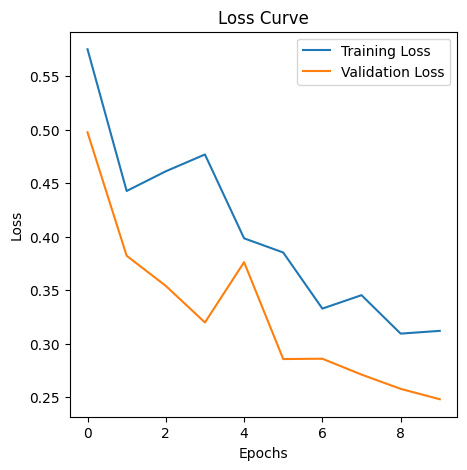

In [43]:
# Plot loss curves for training and validation sets.
# Create a figure with a size of 5x5 inches.
plt.figure(figsize=(5, 5))

# Plot the training loss over epochs.
plt.plot(history.history['loss'], label='Training Loss')

# Plot the validation loss over epochs.
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title of the plot.
plt.title('Loss Curve')

# Label the x-axis as "Epochs" and y-axis as "Loss".
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to distinguish between training and validation curves.
plt.legend()

# Display the plot.
plt.show()


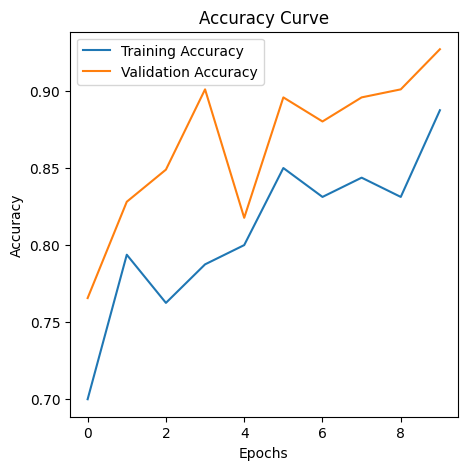

In [44]:
# Plot accuracy curves for training and validation sets.
# Create a new figure with a size of 5x5 inches.
plt.figure(figsize=(5, 5))

# Plot the training accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot the validation accuracy over epochs.
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Set the title of the plot.
plt.title('Accuracy Curve')

# Label the x-axis as "Epochs" and y-axis as "Accuracy".
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to distinguish between training and validation curves.
plt.legend()

# Display the plot.
plt.show()

### Evaluate both models on test data¶

In [45]:
# Load the previously saved models.
# 'extract_feat_model' is the model built using feature extraction (VGG16 without fine-tuning).
# 'fine_tune_model' is the model that has been fine-tuned (some layers of VGG16 unfrozen).
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

In [46]:
IMG_DIM = (150, 150)

# Load test images:
# Get file paths for images in the 'O' and 'R' directories of the test set.
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')

# Take the first 50 images from each category and combine them.
test_files = test_files_O[:50] + test_files_R[:50]

# Load each image, resize to IMG_DIM (150x150), and convert to a numpy array.
test_imgs = [tf.keras.preprocessing.image.img_to_array(
                tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM))
             for img in test_files]
test_imgs = np.array(test_imgs)

# Extract the label for each image based on its parent folder name ('O' or 'R').
test_labels = [Path(fn).parent.name for fn in test_files]

In [47]:
# Convert the images to float32 type and scale pixel values to the range [0, 1].
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

In [48]:
# Lambda function to convert class labels to numeric values:
# 'O' becomes 0 and 'R' becomes 1.
class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]

# Lambda function to convert numeric predictions to class labels:
# If the prediction is less than 0.5, it's 'O'; otherwise, it's 'R'.
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

In [49]:
# Use the two models to predict the classes of the test images.
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert the numeric predictions to class labels ('O' or 'R').
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

In [50]:
# Print a detailed classification report (precision, recall, f1-score, etc.) for each model.
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.83      0.88      0.85        50
           R       0.87      0.82      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.84      0.84      0.84        50
           R       0.84      0.84      0.84        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



In [51]:
# Defining a Function to Plot an Image with Title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    # Display the image.
    plt.imshow(image)
    # Set the title with model name, actual label, and predicted label.
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    # Remove axis for a cleaner look.
    plt.axis('off')
    # Show the plot.
    plt.show()


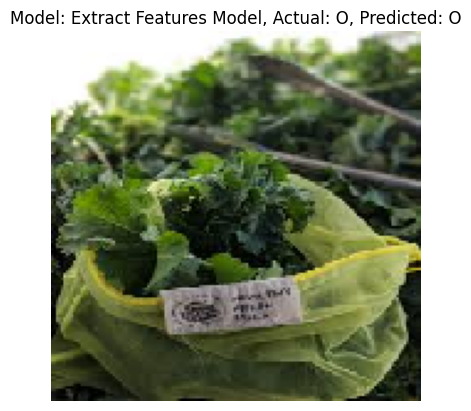

In [52]:
# Do an example and plot the image at index 0 using the Extract Features Model.
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),   # The image is cast to uint8 for correct display.
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
)

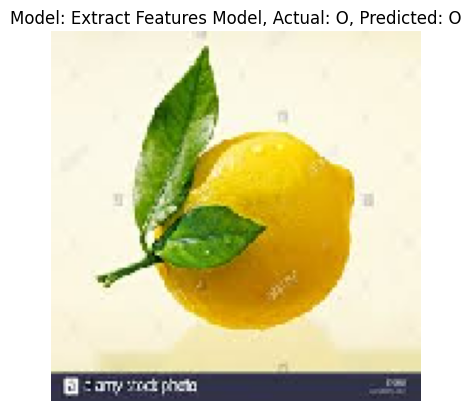

In [53]:
# Plot a Test Image Using Extract Features Model (index_to_plot = 1)

# Set the index of the image we want to plot.
index_to_plot = 1

# Plot the image with title using the Extract Features Model predictions.
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot]
)

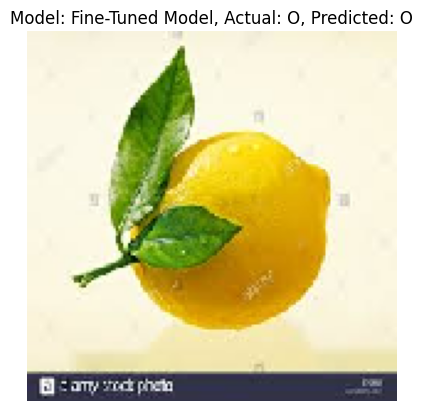

In [54]:
# Plot a Test Image Using Fine-Tuned Model (index_to_plot = 1)

# Again, using index 1 for the test image.
index_to_plot = 1

# Plot the image with title using the Fine-Tuned Model predictions.
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot]
)